In [1]:
from fastai.vision.all import *
import fastai
import timm
import albumentations as A
import torch
import pandas as pd
import numpy as np
torch.cuda.set_device(0)

/opt/anaconda/envs/fastai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [33]:
import os
def create_csvValid(path):
    output_path = os.path.join(path,"..","df_test.csv")
    if (os.path.exists(output_path)):
        output_path_csv = open(output_path, "a")
    else:
        output_path_csv = open(output_path, "w")
        output_path_csv.write("images, class\n")

#         output_path_csv.write(head)

    lista_archivos = list(os.walk(path))
    lista_archivos.sort()
    for carpeta in lista_archivos:
#         print(carpeta[0])
        video = carpeta[0].split(os.path.sep)[-1]
        for files in carpeta[2]:
            if "images.csv" in files:
                leer = open(os.path.join(carpeta[0],files))
                leer.readline()
                for l in leer:
                    output_path_csv.write(video+os.path.sep+"images"+os.path.sep+l)
#                     print(l)

In [34]:
create_csvValid("./dataset77_Marco/test")

In [2]:
dfValid = pd.read_csv('./dataset77_Marco/df_train.csv')
dfTest = pd.read_csv('./dataset77_Marco/df_test.csv')

prueba = dfValid
prueba = prueba.iloc[np.random.permutation(len(prueba))]
prueba = prueba[0:int(len(prueba)*0.1)]
# In[6]:
# Aquí debería hacer dos df diferentes. Uno para entrenamiento y otro para validación. En este caso 
# usa para entrenar el set de entrenamiento y validación. Imagino que la división la hará por programa
# dfValid = dfValid[(dfValid.set == 'training') | (dfValid.set == 'validation')]

# Hay que modificar esto para que haya set de validación. Hacer un vector random y que esté entre las primeras 
# 0.1 posiciones si está se devuelve 
def is_valid(path):
    name = path[0]
#     return (dfValid[dfValid['challenge_id']==name])['set'].values[0]=='validation'
    return (dfValid[dfValid['images']==name]).values[0] in prueba.images.values
    
# In[13]:

def get_class(path):
    name = path[0]
    return (dfValid[dfValid['images']==name])['class']


In [3]:
dfValid.loc[:,'images']=dfValid['images'].apply(lambda x: "./dataset77_Marco/train/"+x)

In [4]:
dfTest.loc[:,'images']=dfTest['images'].apply(lambda x: "./dataset77_Marco/test/"+x)

In [5]:
dfValid['split'] = False
dfTest['split'] = True

In [6]:
dfTotal = pd.concat([dfValid,dfTest])

In [7]:
dfTotal.to_csv('df_total.csv')

In [18]:
def get_dls(presize=512,size=384,M=0,bs=16):
    db = DataBlock(blocks = (ImageBlock, CategoryBlock),
             splitter=ColSplitter(2),
             get_x = ColReader(0,suff='.jpg'),
             get_y=ColReader(1),
             item_tfms = [Resize(presize)], # CropPad(200,200)
             batch_tfms=[*aug_transforms(size=size, min_scale=0.75,do_flip=False,flip_vert=False,
                  max_rotate=0.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                         Normalize.from_stats(*imagenet_stats)])
    dls = db.dataloaders(dfTotal,bs=bs)
    return dls

In [19]:
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='hrnet_w64',monitor='cohen_kappa_score'),
    ReduceLROnPlateau(patience=10)
]

In [20]:
import timm
timm.list_models('*hrnet*')

['hrnet_w18',
 'hrnet_w18_small',
 'hrnet_w18_small_v2',
 'hrnet_w30',
 'hrnet_w32',
 'hrnet_w40',
 'hrnet_w44',
 'hrnet_w48',
 'hrnet_w64']

In [21]:
dlsTrain = get_dls()

learn = Learner(dlsTrain,timm.create_model('hrnet_w64',num_classes=13,pretrained=True),
                metrics=[accuracy,CohenKappa(weights='quadratic'),F1Score(average='macro')], cbs = callbacks,
                loss_func= CrossEntropyLossFlat()).to_fp16()

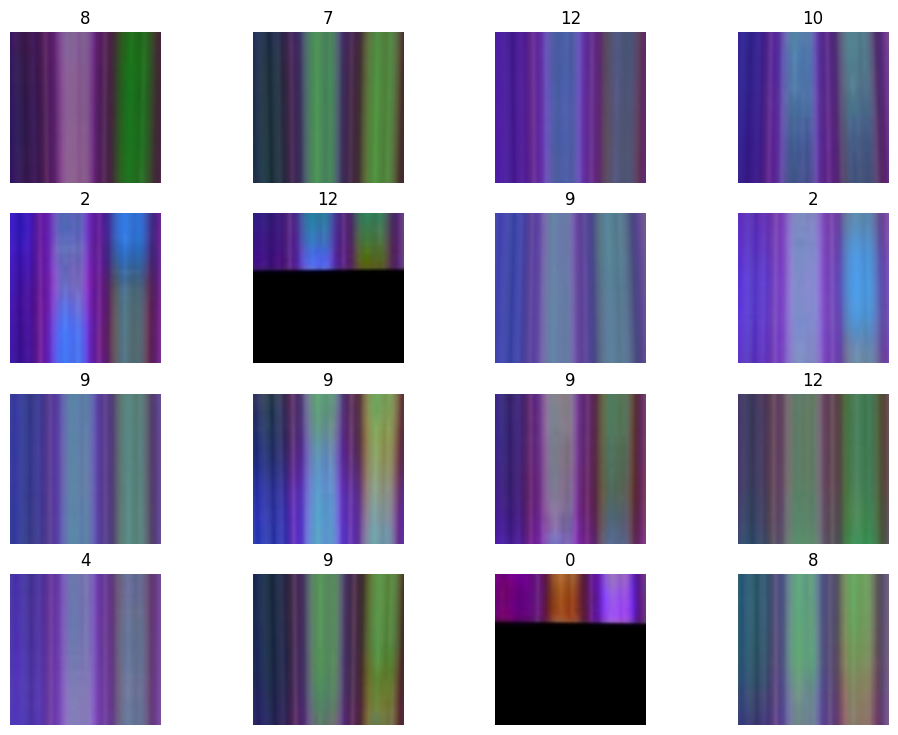

In [22]:
dlsTrain.show_batch(max_n=100, figsize=(12,9))

SuggestedLRs(valley=0.0030199517495930195)

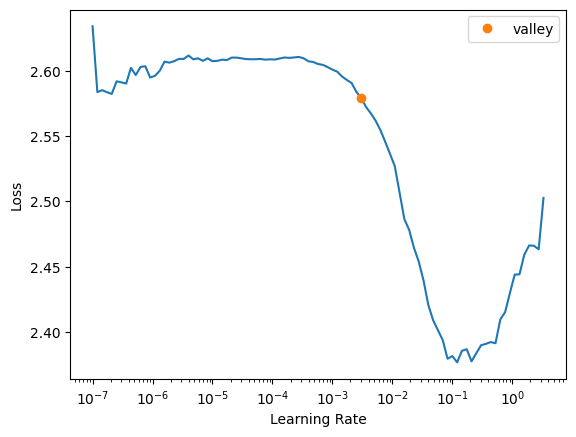

In [23]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,cohen_kappa_score,f1_score,time
0,1.391279,1.427969,0.531441,0.681715,0.370693,04:57


Better model found at epoch 0 with cohen_kappa_score value: 0.6817147287686784.


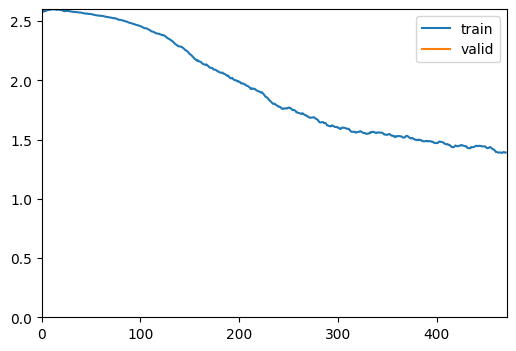

epoch,train_loss,valid_loss,accuracy,cohen_kappa_score,f1_score,time
0,1.137777,1.124646,0.637442,0.768088,0.545096,04:59
1,1.057422,1.032231,0.661516,0.770132,0.577973,04:59
2,1.032522,1.012629,0.670859,0.784668,0.609923,05:00
3,0.920665,0.981471,0.681279,0.784243,0.617913,05:00
4,0.904103,0.947630,0.682716,0.793500,0.620779,05:00
5,0.915554,0.941338,0.681639,0.803419,0.626292,05:00
6,0.890609,0.985365,0.671937,0.805218,0.616924,05:00
7,0.838528,0.944924,0.684513,0.803967,0.630225,05:00
8,0.810899,0.922487,0.690262,0.809575,0.635624,05:00
9,0.770184,0.969401,0.670499,0.805199,0.621677,05:00


Better model found at epoch 0 with cohen_kappa_score value: 0.7680880417496181.


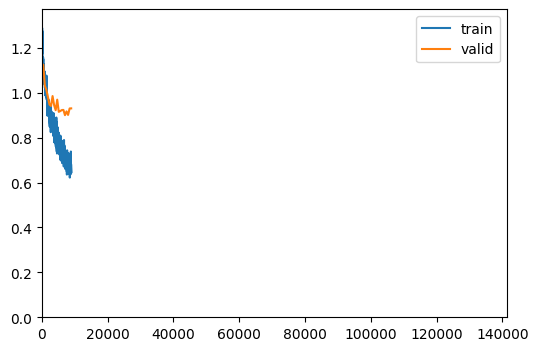

Better model found at epoch 1 with cohen_kappa_score value: 0.7701316139890134.
Better model found at epoch 2 with cohen_kappa_score value: 0.7846679026034357.
Better model found at epoch 4 with cohen_kappa_score value: 0.7935001895011506.
Better model found at epoch 5 with cohen_kappa_score value: 0.803419044391067.
Better model found at epoch 6 with cohen_kappa_score value: 0.805218486158097.
Better model found at epoch 8 with cohen_kappa_score value: 0.8095748098619243.
Better model found at epoch 10 with cohen_kappa_score value: 0.8158808681299443.
Better model found at epoch 11 with cohen_kappa_score value: 0.8181813797006308.
No improvement since epoch 14: early stopping


In [24]:
learn.fine_tune(300,base_lr=0.0030199517495930195)

In [5]:
learn.load('hrnet_w64')

/opt/anaconda/envs/fastai/lib/python3.10/site-packages/fastai/learner.py:59: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [25]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=ColSplitter('split'),
                 get_x = ColReader(0,suff='.jpg'),
                 get_y=ColReader(1),
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(dfTotal,bs=4)

In [26]:
learn.dls = dlsTest

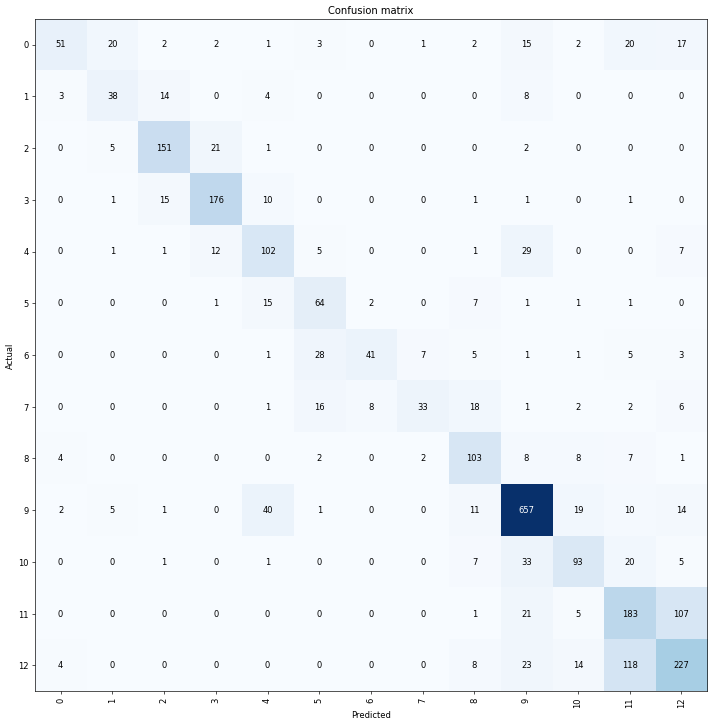

In [27]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [28]:
learn.validate()

Better model found at epoch 0 with cohen_kappa_score value: 0.637869199014747.


(#4) [0.9186608791351318,0.6895436644554138,0.818148500409214,0.637869199014747]

In [ ]:
learn.export(fname='hrnet_w64.pkl')

In [29]:
from sklearn.metrics import accuracy_score, top_k_accuracy_score, f1_score

preds,gt = learn.get_preds()

In [30]:
f1_score(np.argmax(preds,axis=1),gt,average='macro')

0.637869199014747

In [31]:
accuracy_score(np.argmax(preds,axis=1),gt)

0.6895436579231046

In [32]:
with open('resultados_hrnet_w64.txt', 'w') as f:
    f.write('El accuracy obtenido en test es:\n')
    f.write(str(accuracy_score(np.argmax(preds,axis=1),gt)))
    f.write('\nEl F1-score que tenemos en test es:\n')
    f.write(str(f1_score(np.argmax(preds,axis=1),gt,average='macro')))